# Bayesian A/B-Testing

Using A/B testing we can determine which version of a webpage performs better in terms of a target metric, such as click-through rate.

This notebook will implement frequentist A/B and baysian A/B and compare them.

#### Data

For the data, we image there is a two versions of a web page A and B. We display the pages to visitors randomly as see if they clicked a "Buy Now" button based on its color. The collect data until we have a good amount of samples.

$N_A = N_B = 5000$, is the number of vistors per page version

$X_A = 200$ and $X_B = 250$


In [21]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Data
n_a, x_a = 5000, 200
n_b, x_b = 5000, 250


### 1) Frequentist A/B

We do hypothesis testing using the z-score, which measures how far the observed difference in conversion rates is from what we would expect if there were actually no difference. A higher z-score means the difference is less likely to happen by chance. If the z-score is large enough (or equivalently, if the p-value is small enough), we reject the null hypothesis and conclude that one version is likely better.


In [19]:
p_a = x_a / n_a 
p_b = x_b / n_b
print("Conversion Rate A:", p_a)
print("Conversion Rate B:", p_b)

p_total = (x_a + x_b) / (n_a + n_b)
print("Overall Conversion Rate:", p_total)

se = np.sqrt(p_total * (1 - p_total) * (1/n_a + 1/n_b))

z_score = (p_b - p_a) / se
p_value = (1 - stats.norm.cdf(abs(z_score))) * 2

print("Z-score:", round(z_score, 2))
print("P-value:", round(p_value, 3))

Conversion Rate A: 0.04
Conversion Rate B: 0.05
Overall Conversion Rate: 0.045
Z-score: 2.41
P-value: 0.016


The p-value is below the treshold ($\alpha=0.05$), therefore we reject the null hypothesis and conclude B is better at getting vistors to click the buy now button.

### Bayesian A/B

Posterior distributions for the conversion rates of A and B can be modeled as Beta distributions. By choosing a Beta prior (commonly uniform Beta(1,1)), we can update it with observed successes and failures to get the posterior:

$Post_A=Beta(Pri_A + X_A, Pri_A + N_A-X_A)$

We can then use these posteriors to compute the probability that B’s conversion rate is higher than A’s, giving an intuitive measure of which version is likely better

In [33]:
from scipy.stats import beta

# Prior parameters
alpha_prior, beta_prior = 1, 1

# Posterior for A and B
posterior_a = beta(alpha_prior + x_a, beta_prior + n_a - x_a)
posterior_b = beta(alpha_prior + x_b, beta_prior + n_b - x_b)

# Simulate draws from the posterior
samples = 100000
samples_a = posterior_a.rvs(samples)
samples_b = posterior_b.rvs(samples)

# Estimate probability that B > A
prob_b_better = (samples_b > samples_a).mean()

print("Bayesian AB Test:")
print("P(B > A) ≈", prob_b_better)

Bayesian AB Test:
P(B > A) ≈ 0.99225


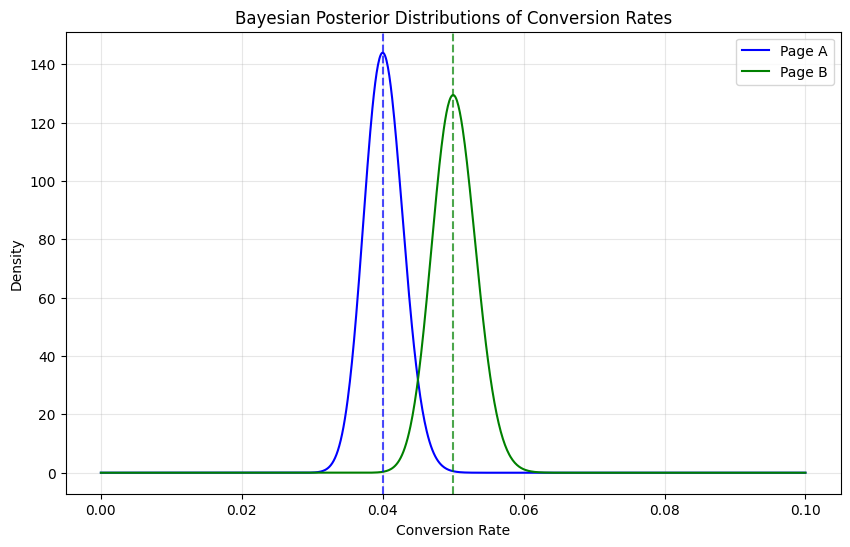

In [32]:
# Define x-axis for plotting
x = np.linspace(0, 0.1, 1000)

# PDF values
pdf_a = posterior_a.pdf(x)
pdf_b = posterior_b.pdf(x)

# Plot
plt.figure(figsize=(10,6))
plt.plot(x, pdf_a, label='Page A', color='blue')
plt.plot(x, pdf_b, label='Page B', color='green')
plt.axvline(x=x_a/n_a, color='blue', linestyle='--', alpha=0.7)
plt.axvline(x=x_b/n_b, color='green', linestyle='--', alpha=0.7)

plt.title("Bayesian Posterior Distributions of Conversion Rates")
plt.xlabel("Conversion Rate")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


This gives a $> 99%$ probability that B is better.

#### Benefits of using the Bayesian method:

- Uses probabilities so it is more interpretable

- Can stop the test early (if for example the prob reaches 99% early on, it is pointless to keep the test going)

- Handles small sample sizes better

- Uses priors